# INFO 2950 Phase 2
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

### Research Question
- detail motive of our question
- detail previous research on our topic

Can we predict the valence (a spectrum indicating negative or positive emotions, with 0 indicating most negative and 1 indicating most positive) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?

Through this journey, we also wondered how danceability correlated with valence and additionally, if we can predict the danceability (with 0.0 being the least danceable and 1.0 being the most danceable) of the general population’s music preference based on the unemployment rate, fed fund rate and other economic variables?

Originally, we went and included all songs in our analysis and found the correlation to be extremely weak. We wondered if this was because the data included a large quantity of songs but people didn't listen to some of them, making them irrelevant. Therefore, we revised our data and filter out unpopular songs with a metric of popularity (a scale out of 100, 100 being the most popular), creating a bottleneck of 70 for our top 10000 song data. After filtering, we saw an increase in correlation and strengthened the possibility that there is a relationship between economic indicators and music sentiments. 



In [135]:
# import all the packages needed
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression

### Data Descriptions
- we're gonna use 3 datasets: billboard, spotify, and unemployment data
    - make sure to detail why we use these datasets
    - answer the questions in the rubric (in data description)
    - what columns are relevant?
- sources for datasets:
    - https://www.kaggle.com/datasets/thedevastator/billboard-hot-100-audio-features?select=Hot+Stuff.csv
    - Un.csv: Another dataset that contains a wider range the monthly unemployment rate data from Jan 1948- Sep 2024 Source: https://fred.stlouisfed.org/series/UNRATE


### Data Cleaning
- include summary of what we did (but do this after describing all the steps we did for cleaning)

- first we're tryna clean the spotify dataset w the billboard dataset.
    - this ensures that the spotify songs that we get were popular for the time it was listened to

First, I try to combine the billboard and spotify first

In [136]:
# importing billboard and spotify csv files
billboard_df = pd.read_csv('billboard.csv')
spotify_df = pd.read_csv('spotify.csv')

In [137]:
# looking at columns
billboard_df.head()

,index,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,0,http://www.billboard.com/charts/hot-100/1965-0...,7/17/1965,34,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,45.0,34,4
1,1,http://www.billboard.com/charts/hot-100/1965-0...,7/24/1965,22,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,34.0,22,5
2,2,http://www.billboard.com/charts/hot-100/1965-0...,7/31/1965,14,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,22.0,14,6
3,3,http://www.billboard.com/charts/hot-100/1965-0...,8/7/1965,10,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,14.0,10,7
4,4,http://www.billboard.com/charts/hot-100/1965-0...,8/14/1965,8,Don't Just Stand There,Patty Duke,Don't Just Stand TherePatty Duke,1,10.0,8,8


In [91]:
spotify_df.head()

,index,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,spotify_track_album,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
0,0,-twistin'-White Silver SandsBill Black's Combo,Bill Black's Combo,-twistin'-White Silver Sands,[],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,¿Dònde Està Santa Claus? (Where Is Santa Claus...,Augie Rios,¿Dònde Està Santa Claus? (Where Is Santa Claus?),['novelty'],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,The Essential Andy Williams,...,-14.063,1.0,0.0315,0.91100,0.000267,0.112,0.150,83.969,4.0,38.0
3,3,...And Then There Were DrumsSandy Nelson,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",1fHHq3qHU8wpRKHzhojZ4a,NaN,172066.0,False,Compelling Percussion,...,-17.278,0.0,0.0361,0.00256,0.745000,0.145,0.801,121.962,4.0,11.0
4,4,...Baby One More TimeBritney Spears,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,https://p.scdn.co/mp3-preview/da2134a161f1cb34...,211066.0,False,...Baby One More Time (Digital Deluxe Version),...,-5.745,0.0,0.0307,0.20200,0.000131,0.443,0.907,92.960,4.0,77.0


In [92]:
# Convert weekID in billboard_df to datetime and extract the month and year
billboard_df['WeekID'] = pd.to_datetime(billboard_df['WeekID'])
billboard_df['Year-Month'] = billboard_df['WeekID'].dt.to_period('M')

In [93]:
# extract relevant columns
billboard_cleaned = billboard_df[['Song', 'Performer', 'Year-Month']]
# columns for spotify dataset that we can use for EDA later
spotify_cleaned = spotify_df[['Song', 'Performer', 'valence', 
                             'danceability', 'spotify_genre', 'tempo']]

# one concern is that there might be duplicate songs in the charts
# but we could explain that there is no concern, because we're analyzing the
# listening pattern and tracking valence of those listeners.

In [94]:
# standardizing song and artist name for merging
billboard_cleaned['Song'] = billboard_cleaned['Song'].str.lower().str.strip()
billboard_cleaned['Performer'] = billboard_cleaned['Performer'].str.lower().str.strip()
spotify_cleaned['Song'] = spotify_cleaned['Song'].str.lower().str.strip()
spotify_cleaned['Performer'] = spotify_cleaned['Performer'].str.lower().str.strip()

/var/folders/kz/g2rg6w5n7px66q8chk6_hpjm0000gn/T/ipykernel_91667/653683805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billboard_cleaned['Song'] = billboard_cleaned['Song'].str.lower().str.strip()
/var/folders/kz/g2rg6w5n7px66q8chk6_hpjm0000gn/T/ipykernel_91667/653683805.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billboard_cleaned['Performer'] = billboard_cleaned['Performer'].str.lower().str.strip()
/var/folders/kz/g2rg6w5n7px66q8chk6_hpjm0000gn/T/ipykernel_91667/653683805.py:4: SettingWith

In [95]:
# merging dataframe
merged_df_music = pd.merge(billboard_cleaned, spotify_cleaned, \
    on=['Song', 'Performer'], how='inner')

In [96]:
# getting unemployment data
unemployment_df = pd.read_csv('un.csv')
unemployment_df.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [148]:
unemployment_df['DATE'] = pd.to_datetime(unemployment_df['DATE'])
unemployment_df['Year-Month'] = unemployment_df['DATE'].dt.to_period('M')

In [149]:
unemployment_cleaned = unemployment_df[['Year-Month', 'UNRATE']]

In [150]:
merged_df = pd.merge(merged_df_music, unemployment_cleaned, on='Year-Month', how='left')

In [151]:
merged_df = merged_df.drop_duplicates()

In [155]:
merged_df = merged_df.dropna()
merged_df

,Song,Performer,Year-Month,valence,danceability,spotify_genre,tempo,UNRATE
0,don't just stand there,patty duke,1965-07,0.568,0.574,['deep adult standards'],82.331,4.4
3,don't just stand there,patty duke,1965-08,0.568,0.574,['deep adult standards'],82.331,4.4
7,don't just stand there,patty duke,1965-09,0.568,0.574,['deep adult standards'],82.331,4.3
14,don't knock my love - pt. 1,wilson pickett,1971-04,0.961,0.731,"['brill building pop', 'classic rock', 'classi...",107.521,5.9
15,don't knock my love - pt. 1,wilson pickett,1971-05,0.961,0.731,"['brill building pop', 'classic rock', 'classi...",107.521,5.9
...,...,...,...,...,...,...,...,...
328787,"how do i live (from ""con air"")",trisha yearwood,1997-09,0.158,0.561,"['contemporary country', 'country', 'country d...",125.865,4.9
328792,nightbird,stevie nicks,1984-03,0.687,0.663,"['album rock', 'heartland rock', 'mellow gold'...",125.220,7.8
328795,love on a rooftop,desmond child,1991-09,0.662,0.613,[],107.967,6.9
328798,hurts to be in love,gino vannelli,1985-12,0.347,0.411,"['classic canadian rock', 'mellow gold', 'soft...",143.494,7.0


In [153]:
merged_df.head()
print(merged_df['Year-Month'].dtype)

period[M]


In [154]:
temp_df = duckdb.sql("""
                     SELECT * FROM merged_df ORDER BY Year-Month""").df()

NotImplementedException: Not implemented Error: Data type 'period[M]' not recognized

In [103]:
merged_df.shape

(84651, 8)

### Exploratory Data Analysis

In [104]:
numeric_columns = ['valence', 'danceability', 'tempo', 'UNRATE']
correlation_matrix = \
    merged_df[numeric_columns].corr()

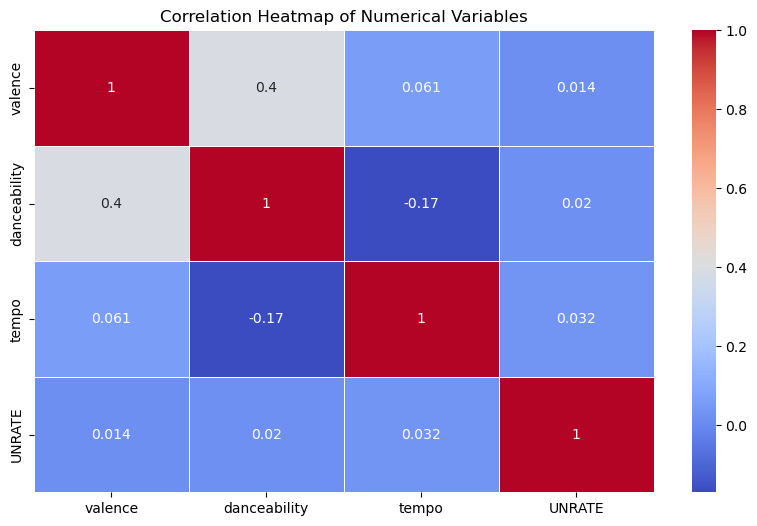

In [105]:
# heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

- describe findings

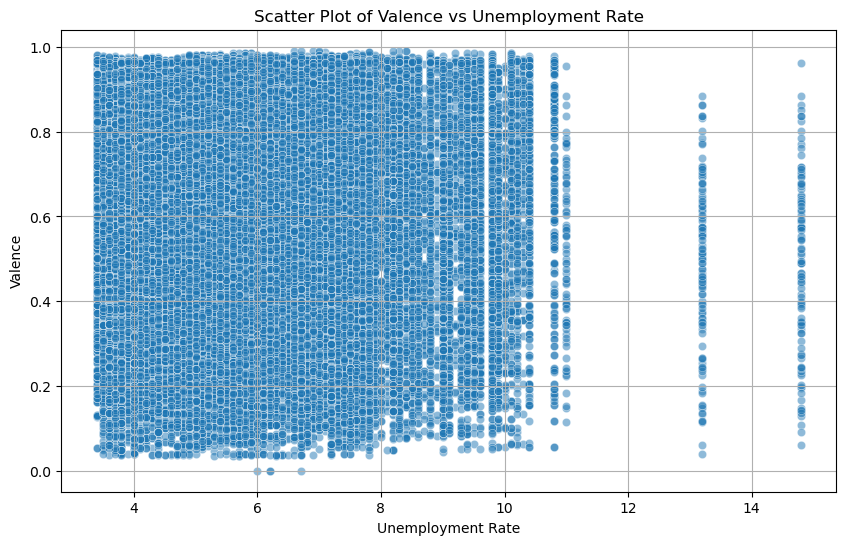

In [106]:
# Plotting 'valence' vs 'UNRATE' to see if there is a relationship between mood of music and unemployment rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='UNRATE', y='valence', alpha=0.5)
plt.title('Scatter Plot of Valence vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Valence')
plt.grid(True)
plt.show()

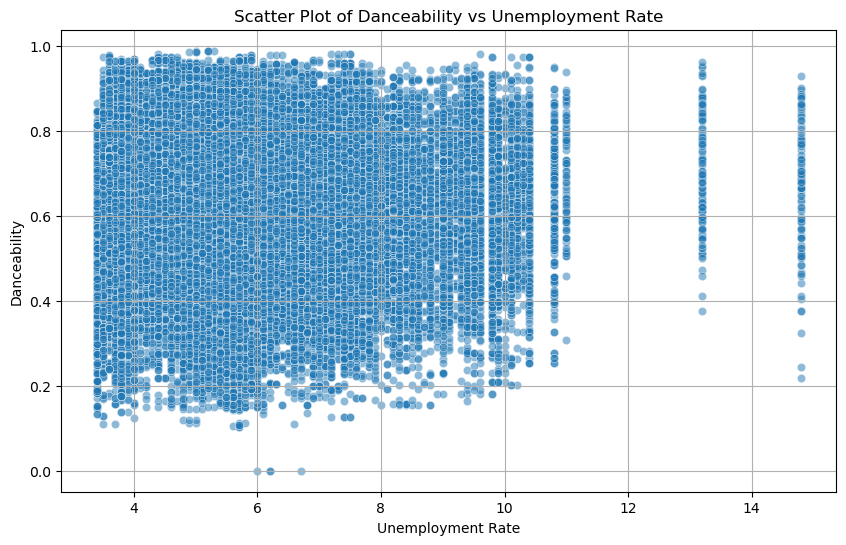

In [107]:
# Scatter plot to visualize danceability and unemployment rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='UNRATE', y='danceability', alpha=0.5)
plt.title('Scatter Plot of Danceability vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Danceability')
plt.grid(True)
plt.show()

In [158]:
# since data looks disorganized, I'm trying to average these plots and see if there is any relationships
unemployment_grouped = merged_df.groupby('UNRATE').agg({'valence': 'mean', 'danceability': 'mean'}).reset_index()

In [159]:
valence_unrate_corr = unemployment_grouped['valence'].corr(unemployment_grouped['UNRATE'])
danceability_unrate_corr = unemployment_grouped['danceability'].corr(unemployment_grouped['UNRATE'])


In [160]:
# running correlation
print(valence_unrate_corr)
print(danceability_unrate_corr)

-0.13003287788810883
0.36605990244634445


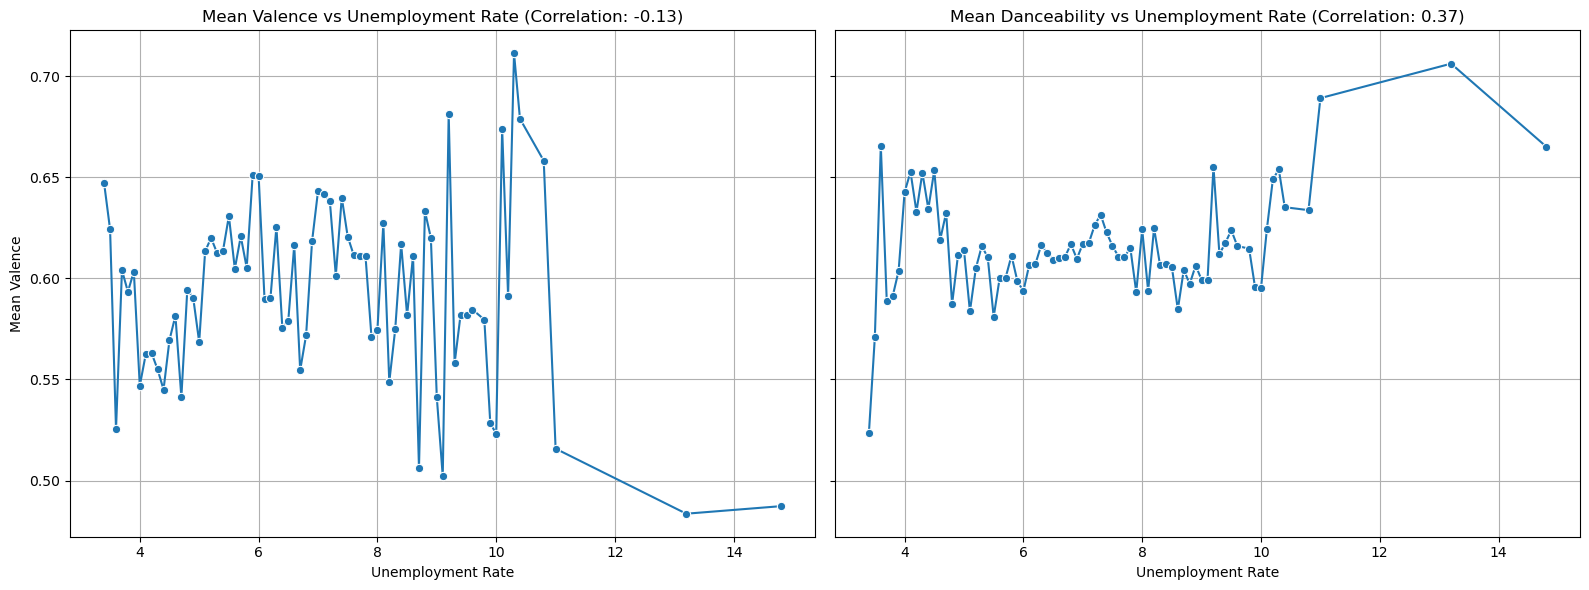

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Mean Valence vs Unemployment Rate
sns.lineplot(ax=axes[0], data=unemployment_grouped, x='UNRATE', y='valence', marker='o')
axes[0].set_title(f'Mean Valence vs Unemployment Rate (Correlation: {valence_unrate_corr:.2f})')
axes[0].set_xlabel('Unemployment Rate')
axes[0].set_ylabel('Mean Valence')
axes[0].grid(True)

# Mean Danceability vs Unemployment Rate
sns.lineplot(ax=axes[1], data=unemployment_grouped, x='UNRATE', y='danceability', marker='o')
axes[1].set_title(f'Mean Danceability vs Unemployment Rate (Correlation: {danceability_unrate_corr:.2f})')
axes[1].set_xlabel('Unemployment Rate')
axes[1].grid(True)

plt.tight_layout()
plt.show()

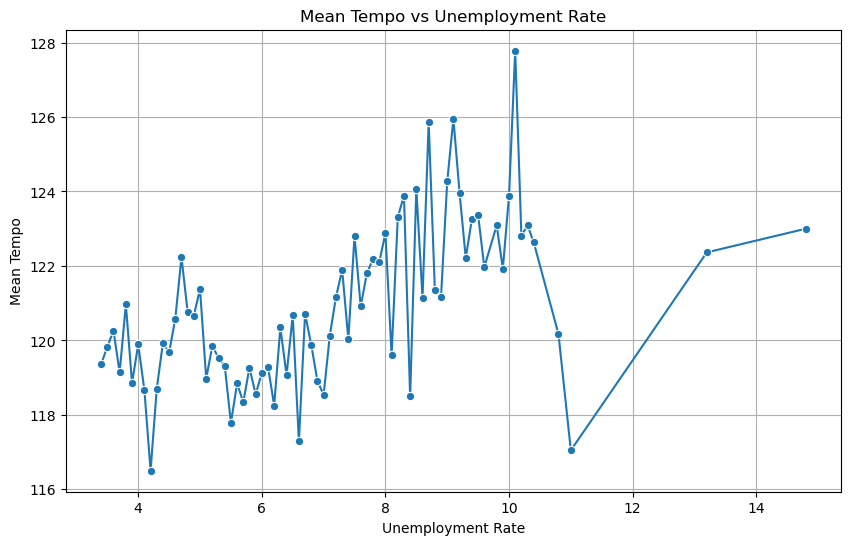

In [112]:
# for tempo
tempo_unemployment_grouped = merged_df.groupby('UNRATE').agg({'tempo': 'mean'}).reset_index()

# Plot mean tempo vs unemployment rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=tempo_unemployment_grouped, x='UNRATE', y='tempo', marker='o')
plt.title('Mean Tempo vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Mean Tempo')
plt.grid(True)
plt.show()

In [113]:
# Analyze unemployment's effect on danceability and valence by genre
# I used chatgpt for this one
# Explode 'spotify_genre' into multiple rows for genres associated with each track
merged_df_exploded = merged_df.explode('spotify_genre')
merged_df_exploded['spotify_genre'] = merged_df_exploded['spotify_genre'].str.strip("[]'").str.lower()

# Group by 'UNRATE' and 'spotify_genre' and calculate mean 'danceability' and 'valence'
genre_grouped = merged_df_exploded.groupby(['UNRATE', 'spotify_genre']).agg({'danceability': 'mean', 'valence': 'mean'}).reset_index()

In [114]:
# Count the frequency of each genre to identify the most common ones
genre_counts = merged_df_exploded['spotify_genre'].value_counts()

# Select the top 10 most common genres for visualization
top_genres = genre_counts.head(10).index

# Filter the dataset to only include the top genres
filtered_genre_grouped = genre_grouped[genre_grouped['spotify_genre'].isin(top_genres)]

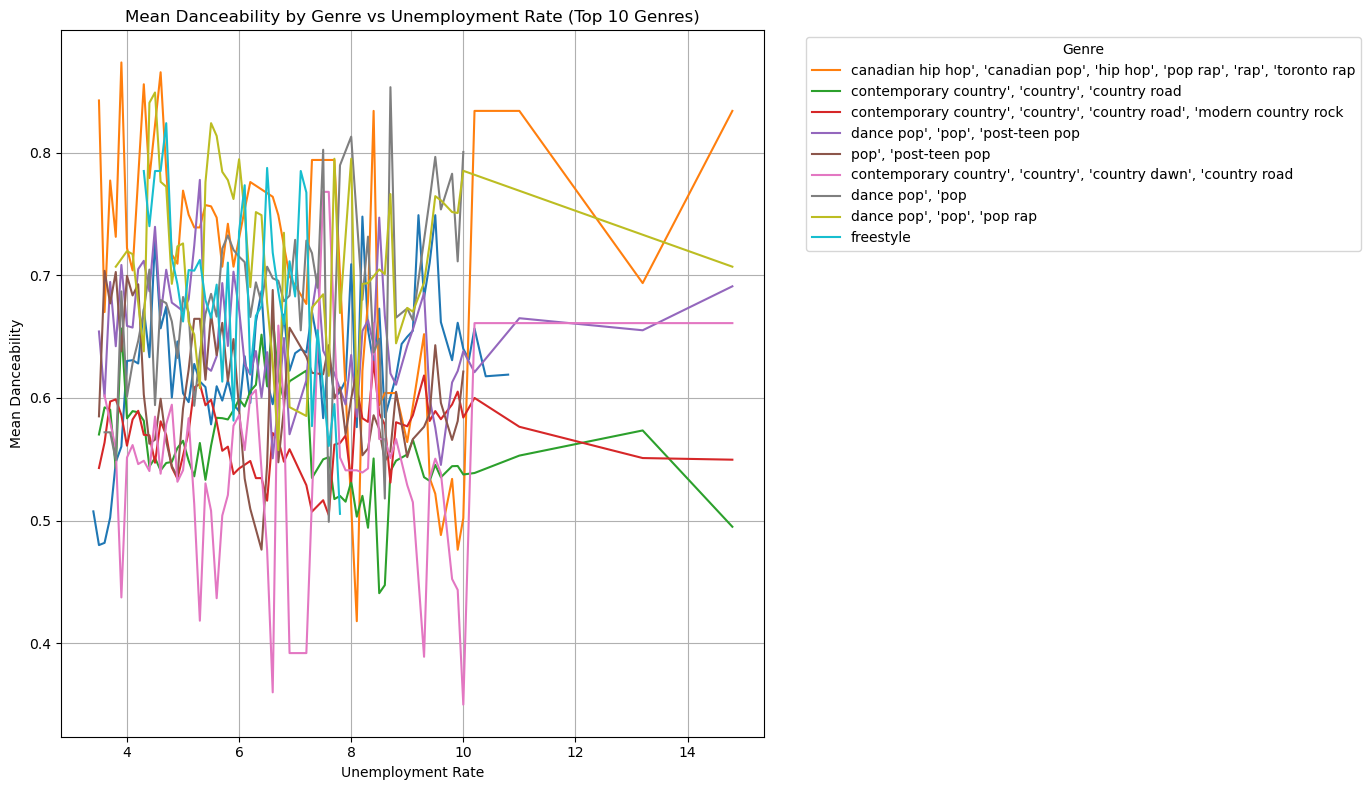

In [115]:
# Plot danceability by genre vs unemployment rate (for top genres)
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_genre_grouped, x='UNRATE', y='danceability', hue='spotify_genre', palette='tab10')
plt.title('Mean Danceability by Genre vs Unemployment Rate (Top 10 Genres)')
plt.xlabel('Unemployment Rate')
plt.ylabel('Mean Danceability')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

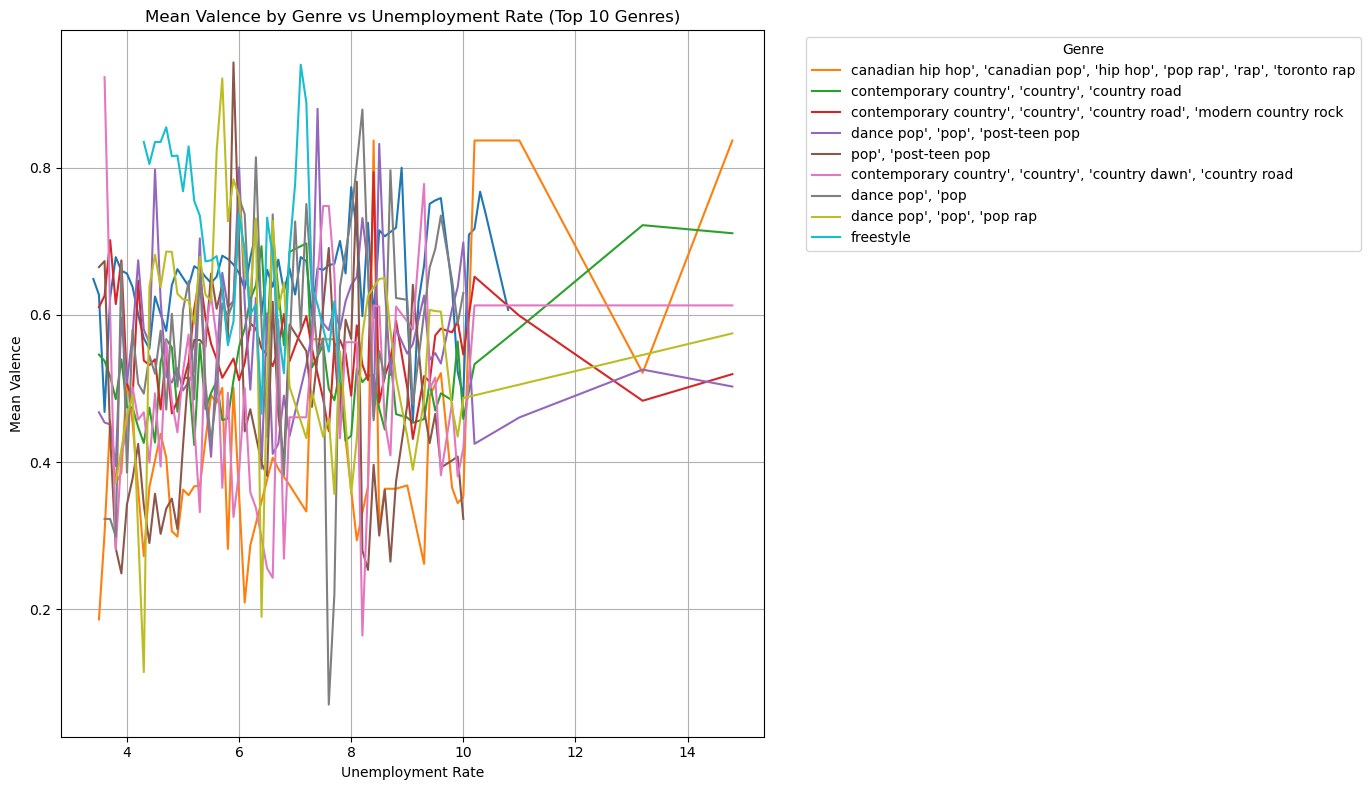

In [116]:
# Plot valence by genre vs unemployment rate (for top genres)
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_genre_grouped, x='UNRATE', y='valence', hue='spotify_genre', palette='tab10')
plt.title('Mean Valence by Genre vs Unemployment Rate (Top 10 Genres)')
plt.xlabel('Unemployment Rate')
plt.ylabel('Mean Valence')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [117]:
merged_df['Year'] = merged_df['Year-Month'].dt.year
merged_df['Decade'] = (merged_df['Year'] // 10) * 10

In [118]:
decade_grouped = merged_df.groupby('Decade').agg({'valence': 'mean', 'danceability': 'mean', 'UNRATE': 'mean'}).reset_index()

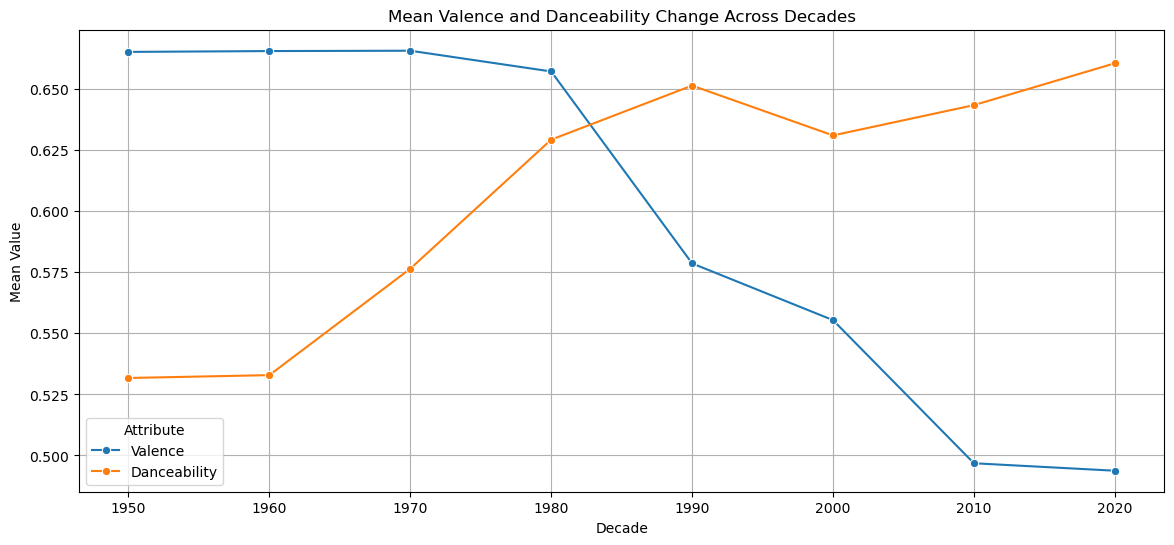

In [119]:
# Plot valence and danceability change across decades
plt.figure(figsize=(14, 6))
sns.lineplot(data=decade_grouped, x='Decade', y='valence', marker='o', label='Valence')
sns.lineplot(data=decade_grouped, x='Decade', y='danceability', marker='o', label='Danceability')
plt.title('Mean Valence and Danceability Change Across Decades')
plt.xlabel('Decade')
plt.ylabel('Mean Value')
plt.legend(title='Attribute')
plt.grid(True)
plt.show()

In [120]:
# Calculate correlations between 'valence', 'danceability', and 'Year'
correlation_matrix_time = merged_df[['valence', 'danceability', 'Year']].corr()
correlation_matrix_time

,valence,danceability,Year
valence,1.000000,0.395735,-0.270844
danceability,0.395735,1.000000,0.257262
Year,-0.270844,0.257262,1.000000


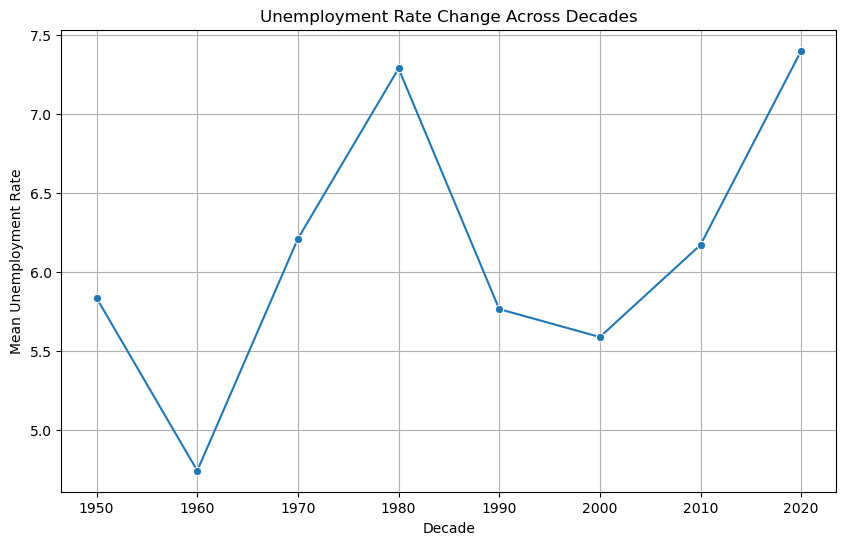

In [121]:
# Plot unemployment rate change across decades
plt.figure(figsize=(10, 6))
sns.lineplot(data=decade_grouped, x='Decade', y='UNRATE', marker='o')
plt.title('Unemployment Rate Change Across Decades')
plt.xlabel('Decade')
plt.ylabel('Mean Unemployment Rate')
plt.grid(True)
plt.show()
